# Imports

In [30]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)

In [31]:
# notice that they have target_gender or target_race prefix, but we'll replace them later
protected_subgroups =['male', 'female', 'transgender', 'white', 'black', 'asian']
attributes = ['gender', 'race']
figsize = (14,8)
epsilon_list = [0.5, 1.0, 3.0, 6.0, 9.0]
runs = 3
linewidth = 3.5
markersize = 13
dataset_name = 'jigsaw'
model_name = 'bert-base-uncased'
markers = ['o', 'v', 's', 'x',  'h', 'D', '^', '>', 'p', '<', '*', 'P',  '.', '+']

output_folder = f'../../results/{dataset_name}/average/{model_name}'
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

# Average bias and overall results

## Load bias and results

In [32]:
bias_df_dict = {}
overall_results_dict = {}

for run in range(1, runs+1):
    run_folder = f'../../results/{dataset_name}/run {run}'
    model_folder = os.path.join(run_folder, model_name)

    normal_folder = os.path.join(model_folder, 'normal')
    bias_df = pd.read_csv(os.path.join(normal_folder, 'bias.csv'))
    overall_results = pd.read_csv(os.path.join(normal_folder, 'overall_results.csv'))
    if run ==1:
        bias_df_dict['None'] = [bias_df]
        overall_results_dict['None'] = [overall_results]
    else:
        bias_df_dict['None'].append(bias_df)
        overall_results_dict['None'].append(overall_results)

    for epsilon in epsilon_list:
        dp_folder = os.path.join(model_folder, f'epsilon {epsilon}')
        
        bias_df = pd.read_csv(os.path.join(dp_folder, 'bias.csv'))
        overall_results = pd.read_csv(os.path.join(dp_folder, 'overall_results.csv'))

        if run ==1:
            bias_df_dict[epsilon] = [bias_df]
            overall_results_dict[epsilon] = [overall_results]
        else:
            bias_df_dict[epsilon].append(bias_df)
            overall_results_dict[epsilon].append(overall_results)

## Concatenate. Dump average

In [33]:
for epsilon in ['None']+epsilon_list:
    bias_df_dict[epsilon] = pd.concat(bias_df_dict[epsilon])
    mean = bias_df_dict[epsilon].groupby('fairness_metrics').aggregate('mean').reset_index()
    mean.round(3).to_csv(
        os.path.join(output_folder, f'bias_epsilon_{epsilon}.csv'), 
        index=False
    )

    overall_results_dict[epsilon] = pd.concat(overall_results_dict[epsilon])
    mean = overall_results_dict[epsilon].groupby('metrics').aggregate('mean').reset_index()
    mean.round(3).to_csv(
        os.path.join(output_folder, f'overall_results_epsilon_{epsilon}.csv'), 
        index=False
    )

# Import plotting libraries

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 2)

import matplotlib as mpl
mpl.rcParams['lines.markersize'] = markersize
mpl.rcParams['lines.linewidth'] = linewidth

formatter = StrMethodFormatter('{x:,.2f}')

## Boxplot

In [35]:
dictionary = {
    'Subgroup': [],
    'Metric': [],
    'Train Type': []
}
metric= 'eqOdd'

def key_map(key):
    if key=='None':
        return 'Non-DP'
    return f'ε <={key}'

for group in protected_subgroups:
    for train_type in bias_df_dict.keys():
        bias_df = bias_df_dict[train_type]
        values = bias_df[bias_df['fairness_metrics']==metric][group].values
        dictionary['Metric'].extend(values)
        dictionary['Subgroup'].extend([group]*len(values))
        dictionary['Train Type'].extend([key_map(train_type)]*len(values))

df = pd.DataFrame(dictionary)

In [36]:
hue_order = df['Train Type'].unique()
hue_order = [hue_order[0]] + sorted(hue_order[1:], reverse=True)
hue_order

['Non-DP', 'ε <=9.0', 'ε <=6.0', 'ε <=3.0', 'ε <=1.0', 'ε <=0.5']

In [37]:
# this returns the df with an increasing privacy order of Train type
def order(df):
    return df.set_index('Train Type').reindex(hue_order).reset_index()

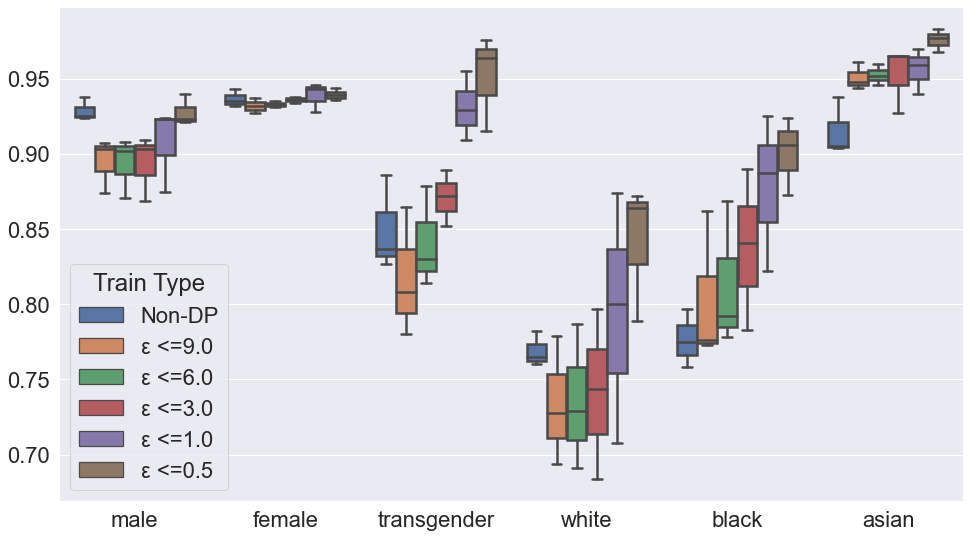

In [38]:
plt.figure(figsize=figsize)
sns.boxplot(x = 'Subgroup', y = 'Metric', hue='Train Type', hue_order=hue_order, data = df, linewidth=2.5)
plt.xlabel('')
plt.ylabel('')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'eodds_boxplot.pdf'))

# Overall result

In [39]:
total = []
for epsilon in ['None']+epsilon_list:
    mean = overall_results_dict[epsilon].groupby('metrics').aggregate('mean').reset_index()
    mean['Train Type'] = key_map(epsilon)
    total.append(mean)

In [40]:
total_df = pd.concat(total)
total_df.head()

,metrics,male,female,transgender,white,black,asian,Total,Train Type
0,accuracy,0.801000,0.821667,0.674333,0.612667,0.639000,0.858667,0.911333,Non-DP
1,auc,0.895333,0.897667,0.796667,0.797667,0.810000,0.887000,0.946000,Non-DP
2,f1_score,0.556667,0.539667,0.493333,0.569333,0.607333,0.483667,0.593333,Non-DP
3,false positive rate,0.203000,0.171667,0.352667,0.490667,0.468000,0.122333,0.080000,Non-DP
4,precision,0.420333,0.413667,0.360667,0.427000,0.469000,0.374333,0.469000,Non-DP


In [41]:
total_df[total_df['metrics'].isin(['false positive rate'])][['metrics', 'Total', 'Train Type']].round(3)

,metrics,Total,Train Type
3,false positive rate,0.080,Non-DP
3,false positive rate,0.111,ε <=0.5
3,false positive rate,0.113,ε <=1.0
3,false positive rate,0.105,ε <=3.0
3,false positive rate,0.103,ε <=6.0
3,false positive rate,0.102,ε <=9.0


## Total dataset

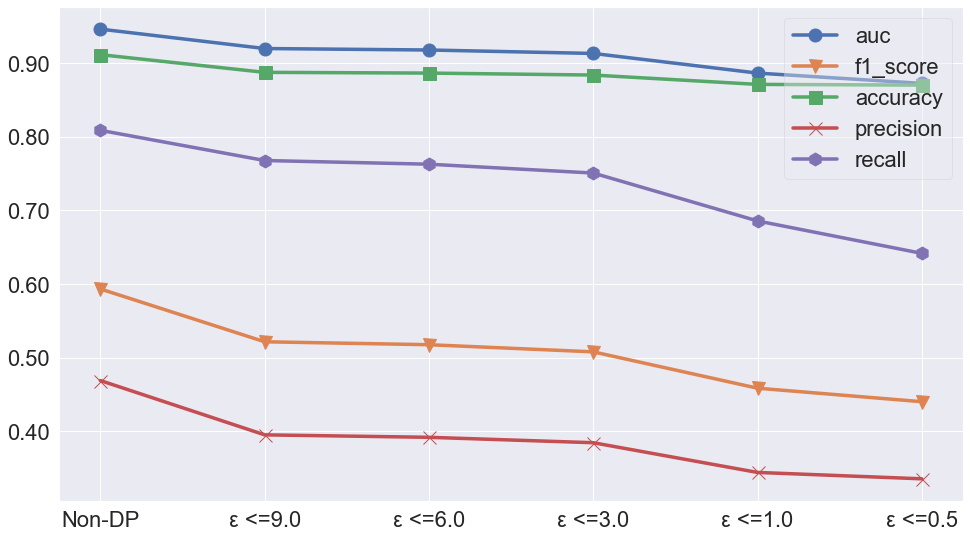

In [42]:
selected_metrics = ['auc', 'f1_score', 'accuracy', 'precision', 'recall']
plt.figure(figsize=figsize)
for i, selected_metric in enumerate(selected_metrics):
    selected_df = total_df[total_df['metrics']==selected_metric]
    selected_df = order(selected_df)
    plt.plot(selected_df["Train Type"], selected_df["Total"], label=selected_metric, marker=markers[i])

plt.legend(loc='upper right', fancybox=True, framealpha=0.4)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'overall_total.pdf'))
plt.show()

## Plot by metric

In [43]:
def plot_by_metric(selected_metric, title=None, figure_name=None):
    plt.figure(figsize=figsize)
    selected_df = total_df[total_df['metrics']==selected_metric]
    selected_df = order(selected_df)

    for i, identity in enumerate(protected_subgroups):
        plt.plot(selected_df["Train Type"], selected_df[identity], label=identity, marker=markers[i])

    plt.legend(loc='upper right', fancybox=True, framealpha=0.4)
    plt.gca().yaxis.set_major_formatter(formatter)
    if title:
        plt.title(title)
    plt.tight_layout()
    if figure_name:
        plt.savefig(os.path.join(output_folder, figure_name))
    plt.show()

auc


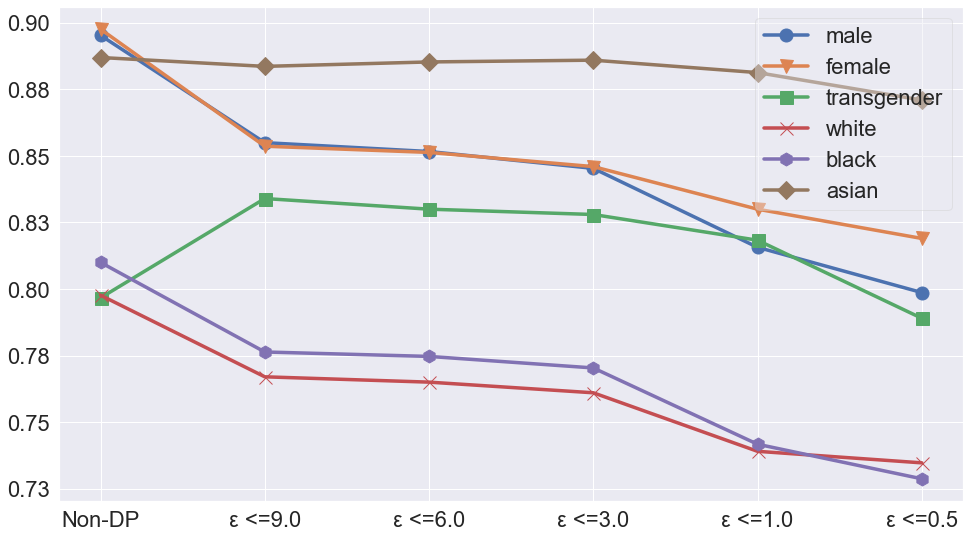

f1_score


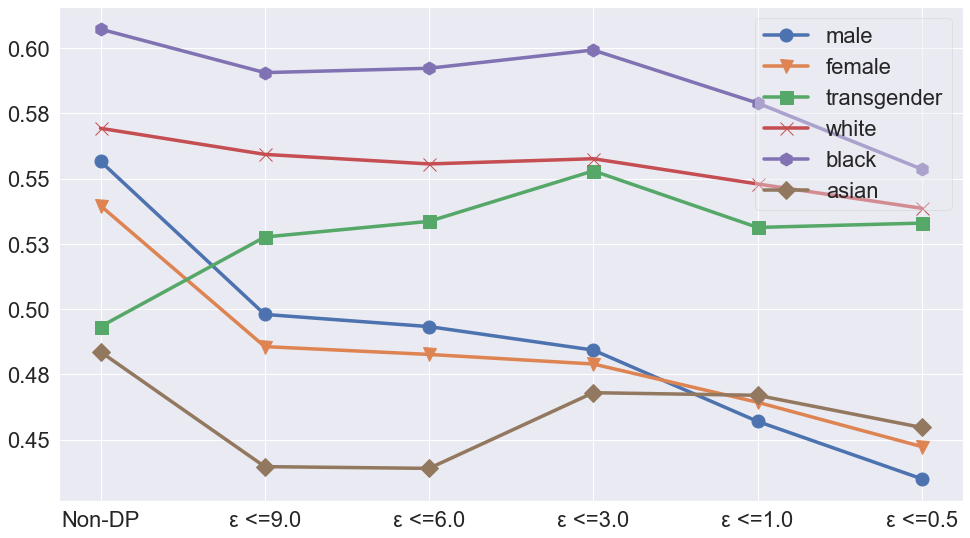

accuracy


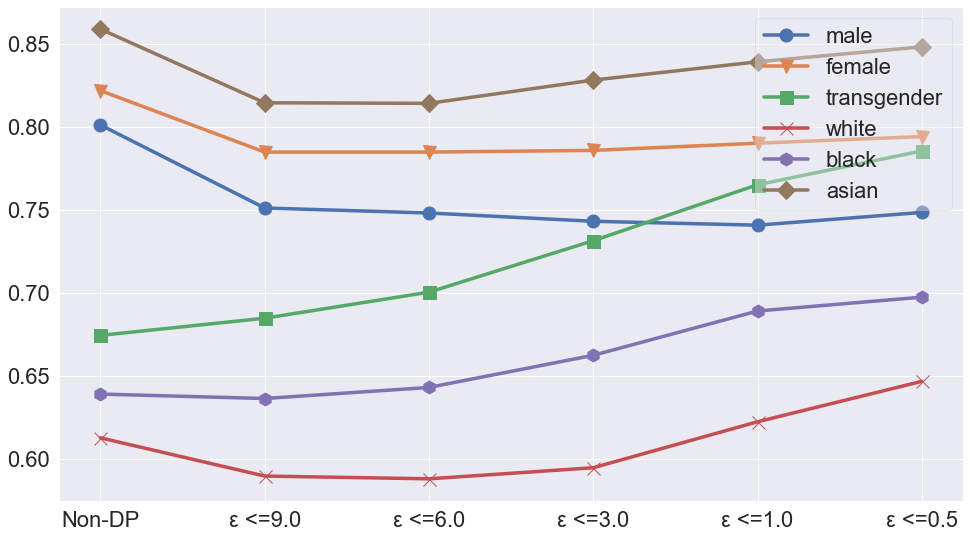

precision


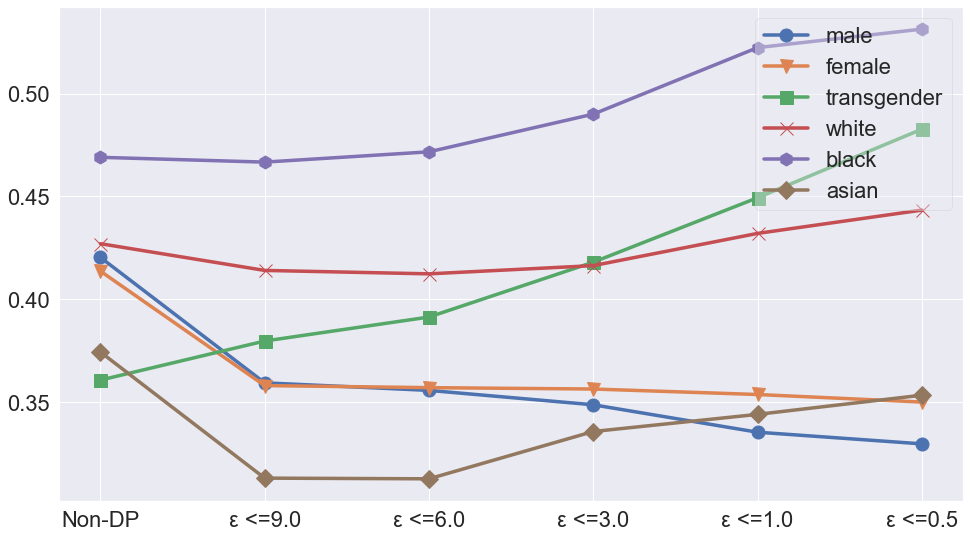

recall


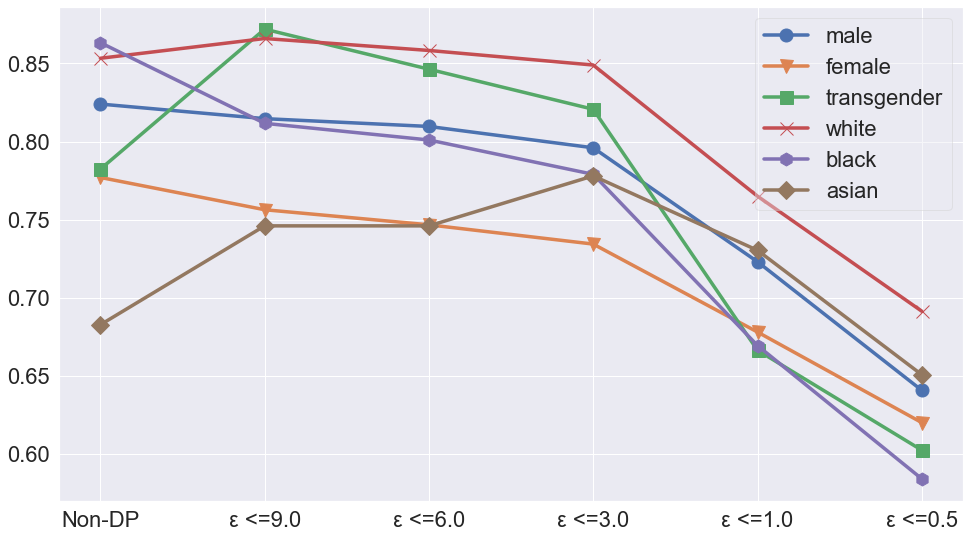

In [44]:
for metric in selected_metrics:
    print(metric)
    plot_by_metric(metric, figure_name=f'{metric}.pdf')

# Bias

In [45]:
metric_column = 'fairness_metrics'

total = []
for epsilon in ['None']+epsilon_list:
    mean = bias_df_dict[epsilon].groupby(metric_column).aggregate('mean').reset_index()
    mean['Train Type'] = key_map(epsilon)
    total.append(mean)

total_df = pd.concat(total)
total_df.head()

,fairness_metrics,male,female,transgender,white,black,asian,Train Type
0,auc,0.895333,0.897667,0.796667,0.797667,0.810000,0.887000,Non-DP
1,bnsp,0.956000,0.948333,0.940000,0.962667,0.959667,0.924000,Non-DP
2,bpsn,0.886000,0.900667,0.837667,0.780000,0.792000,0.921667,Non-DP
3,eqOdd,0.929000,0.936667,0.850000,0.769000,0.776667,0.915667,Non-DP
4,eqOpp0,0.874333,0.905667,0.726667,0.585333,0.609333,0.957000,Non-DP


In [46]:
# bias_metrics = total_df[metric_column].unique()
print(f'Available bias metrics {total_df[metric_column].unique()}')
bias_metrics = ['eqOdd', 'parity', 'p-accuracy', 'auc', 'bnsp', 'bpsn']

Available bias metrics ['auc' 'bnsp' 'bpsn' 'eqOdd' 'eqOpp0' 'eqOpp1' 'negAEG' 'p-accuracy'
 'parity' 'posAEG']


In [47]:
temp1 = total_df[(total_df['Train Type']=='Non-DP') & total_df['fairness_metrics'].isin(['auc', 'bpsn', 'bnsp'])].drop(columns=['fairness_metrics', 'Train Type'])
temp2 = total_df[(total_df['Train Type']=='ε <=0.5') & total_df['fairness_metrics'].isin(['auc', 'bpsn', 'bnsp'])].drop(columns=['fairness_metrics', 'Train Type'])
(temp1 - temp2).round(3)

,male,female,transgender,white,black,asian
0,0.097,0.079,0.008,0.063,0.081,0.016
1,0.064,0.067,0.082,0.058,0.098,0.036
2,0.109,0.087,0.028,0.088,0.034,0.067


## Plot by subgroup

In [48]:
def plot_bias_by_subgroup(subgroup, title=None, figure_name= None):
    plt.figure(figsize=figsize)
    
    for i, bias_metric in enumerate(bias_metrics):
        df = total_df[total_df[metric_column]==bias_metric]
        df = order(df)
        plt.plot(df["Train Type"], df[subgroup], label=bias_metric, marker=markers[i])

    plt.legend(loc='upper right', fancybox=True, framealpha=0.5)

    plt.gca().yaxis.set_major_formatter(formatter)
    if title:
        plt.title(title)
    plt.tight_layout()
    if figure_name:
        plt.savefig(os.path.join(output_folder, figure_name))

    plt.show()

male


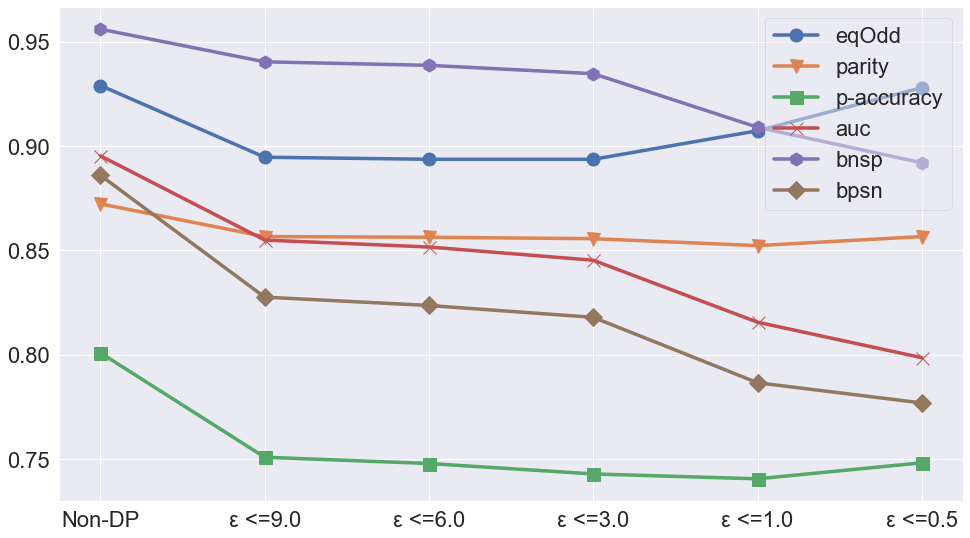

female


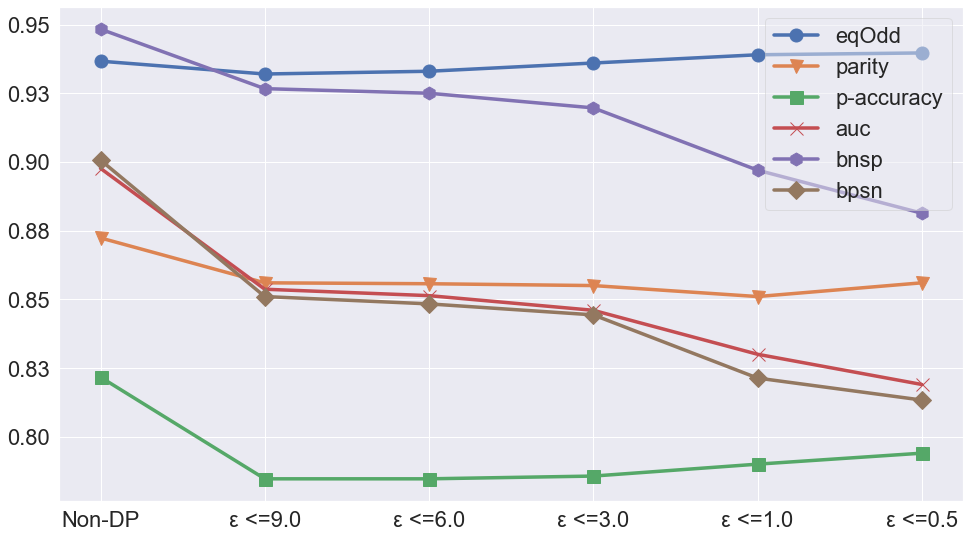

transgender


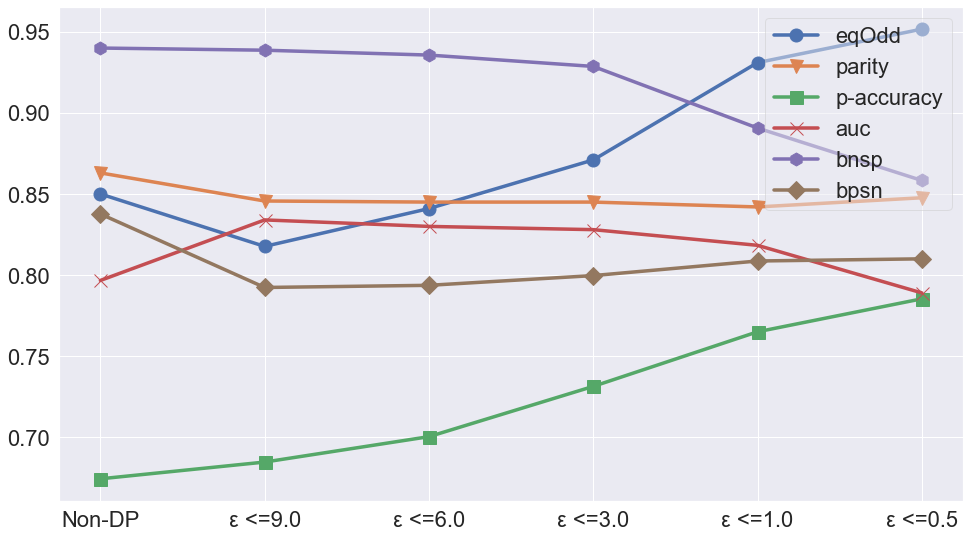

white


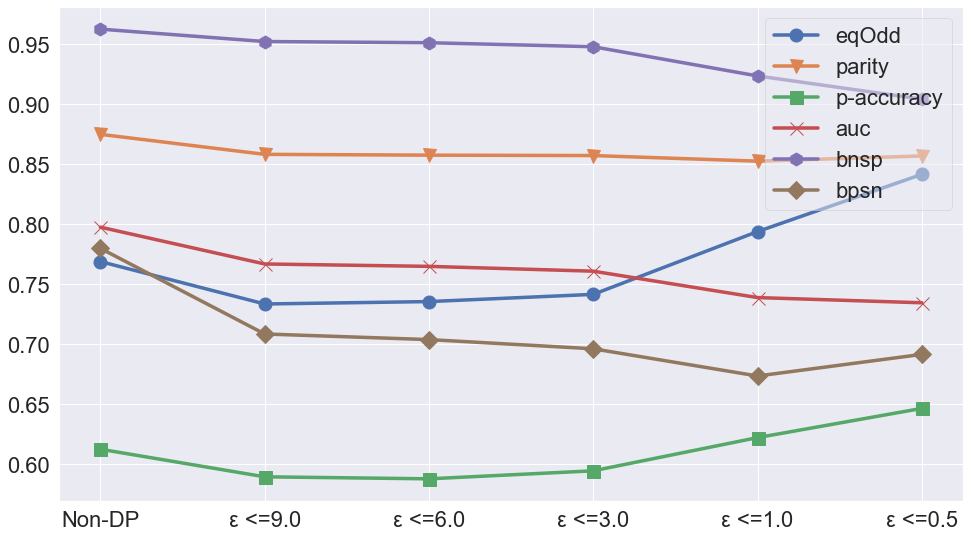

black


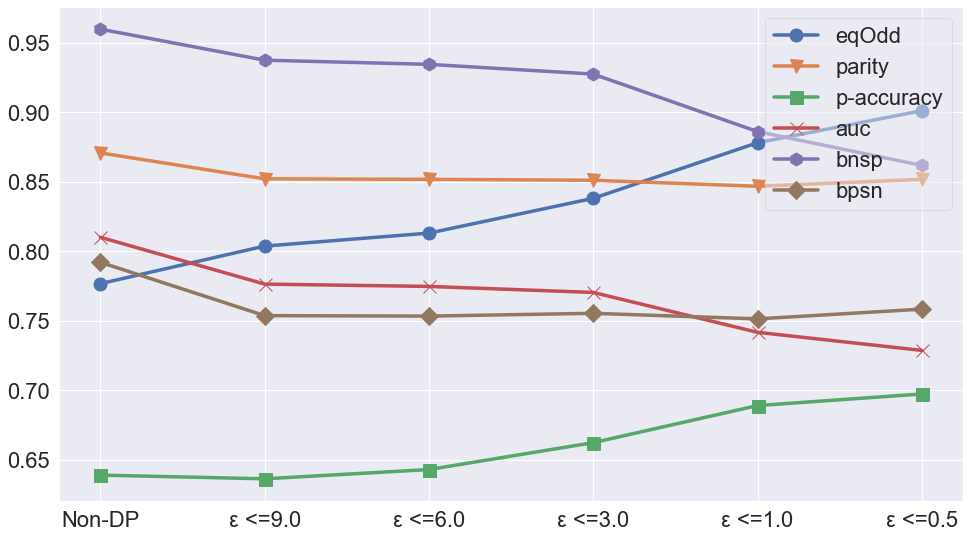

asian


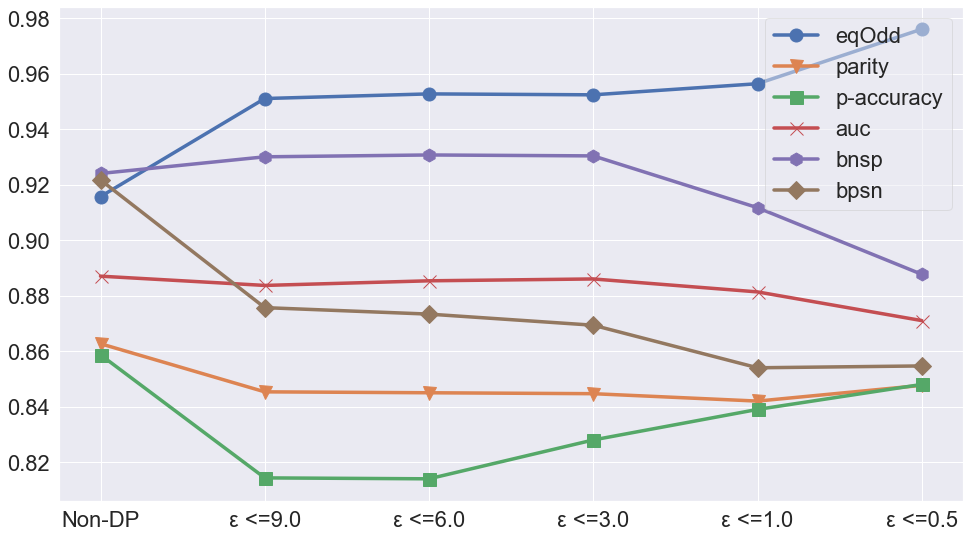

In [49]:
for group in protected_subgroups:
    print(group)
    plot_bias_by_subgroup(group, figure_name=f'{group}_bias.pdf')

## Plot bias by metric

In [50]:
def plot_bias_by_metric(selected_metric, title=None, figure_name=None):
    plt.figure(figsize=figsize)
    df = total_df[total_df[metric_column]==selected_metric]
    df = order(df)

    for i, group in enumerate(protected_subgroups):
        plt.plot(df["Train Type"], df[group], label=group, marker=markers[i])

    plt.legend(loc='upper right', fancybox=True, framealpha=0.4)
    # https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-labels
    plt.gca().yaxis.set_major_formatter(formatter)
    if title:
        plt.title(title)
    plt.tight_layout()
    if figure_name:
        plt.savefig(os.path.join(output_folder, figure_name))
    plt.show()

eqOdd


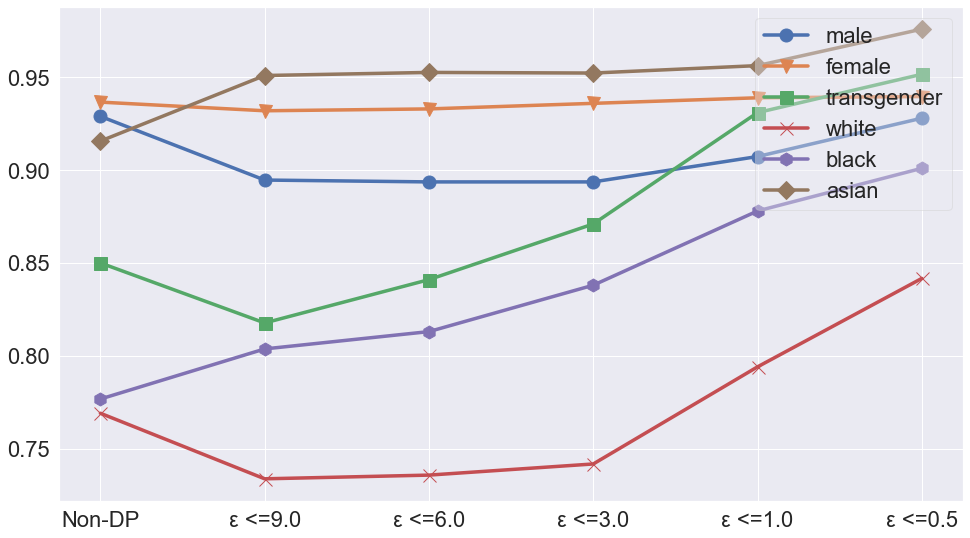

parity


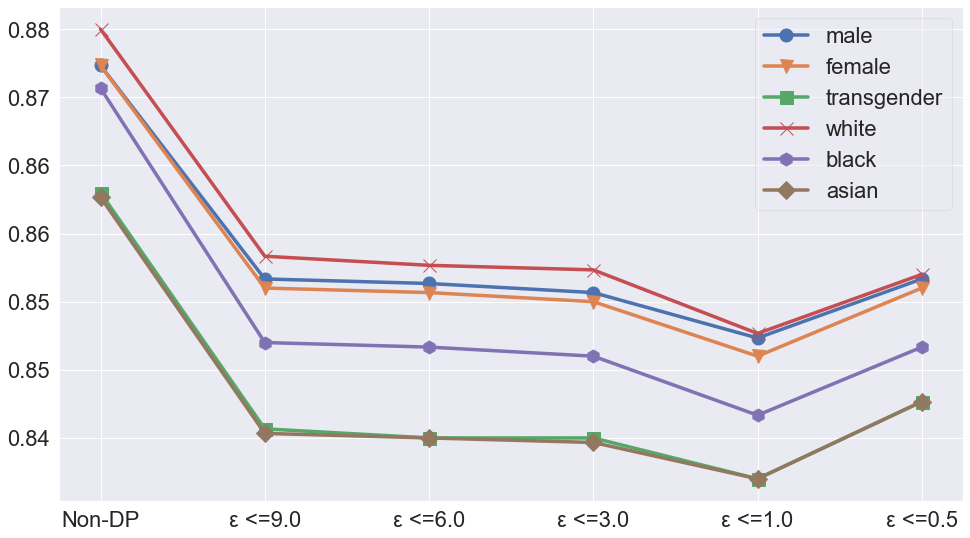

p-accuracy


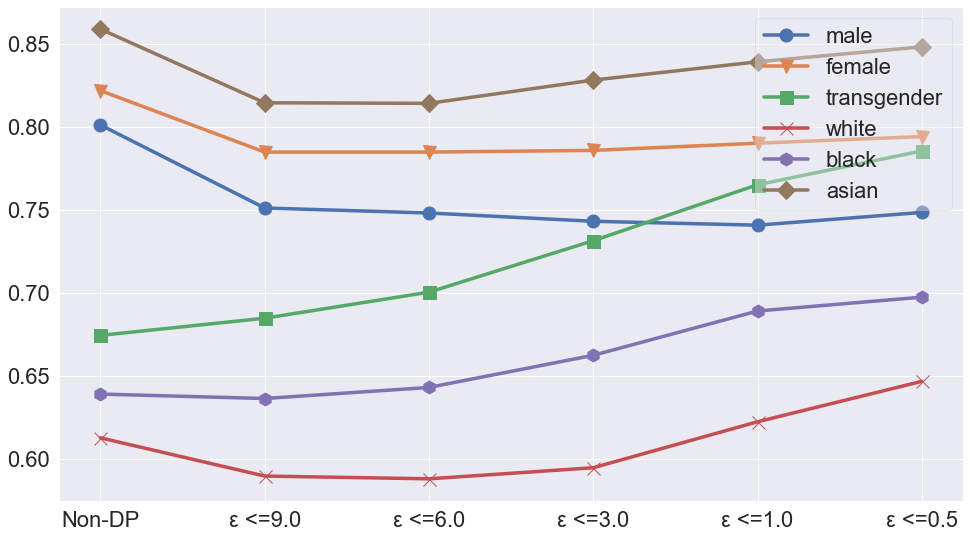

auc


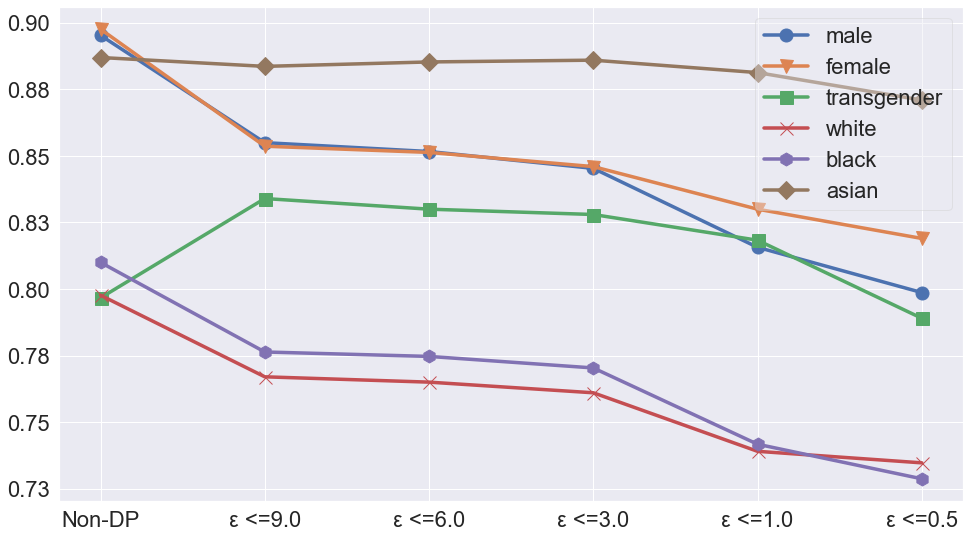

bnsp


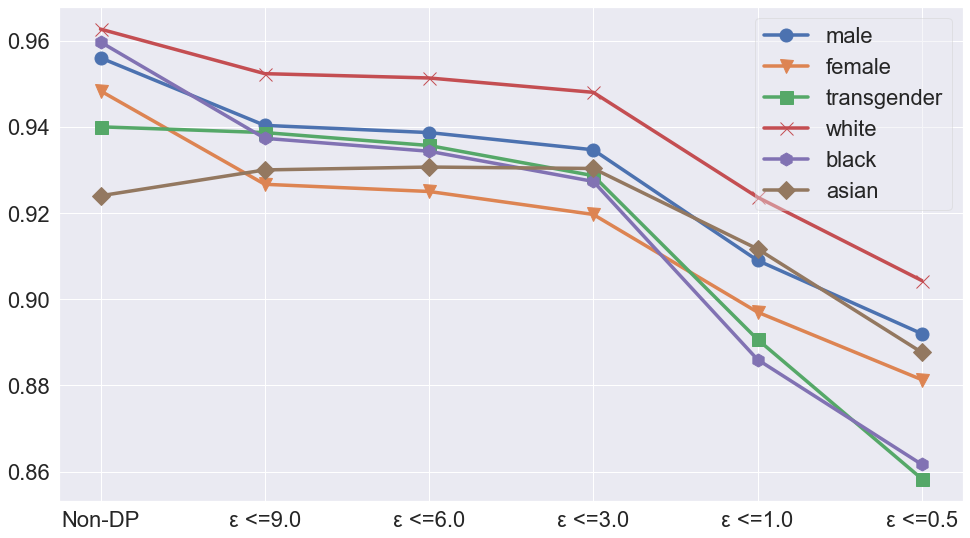

bpsn


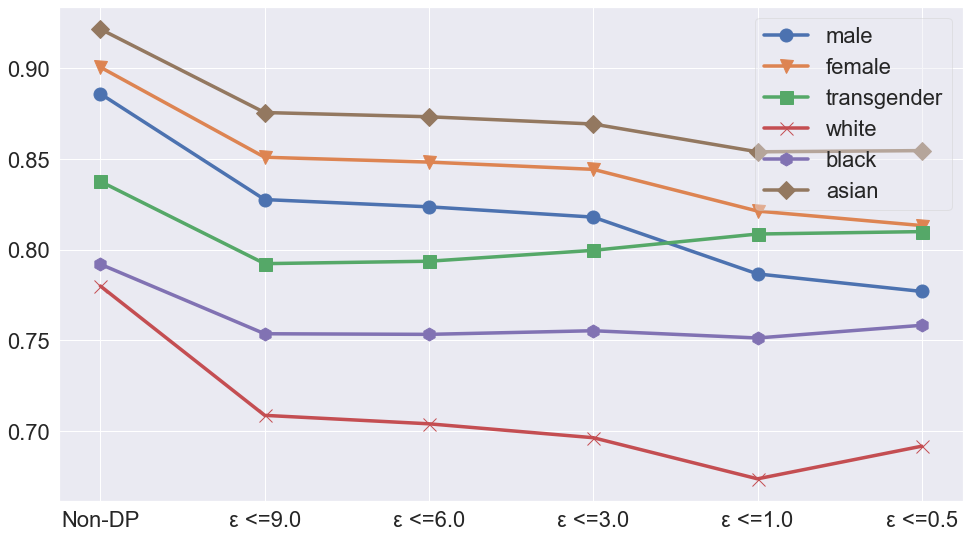

eqOpp0


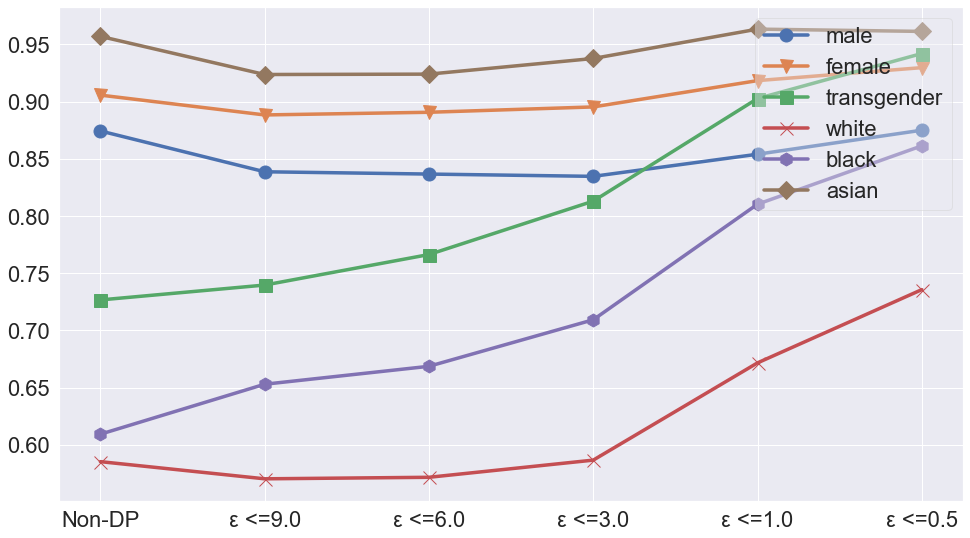

eqOpp1


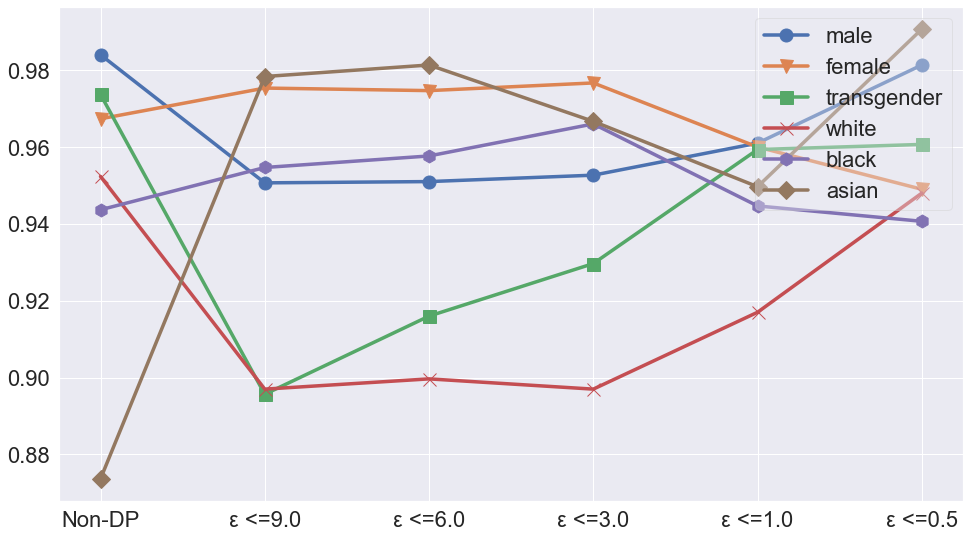

In [51]:
for metric in bias_metrics+['eqOpp0', 'eqOpp1']:
    print(metric)
    plot_bias_by_metric(metric, figure_name=f'{metric}.pdf')

### Average Equality Gaps

posAEG


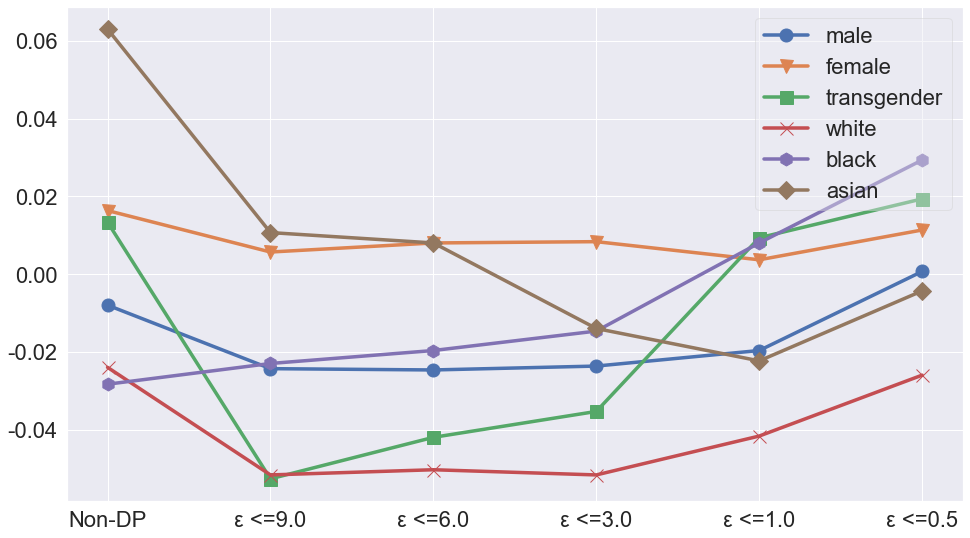

negAEG


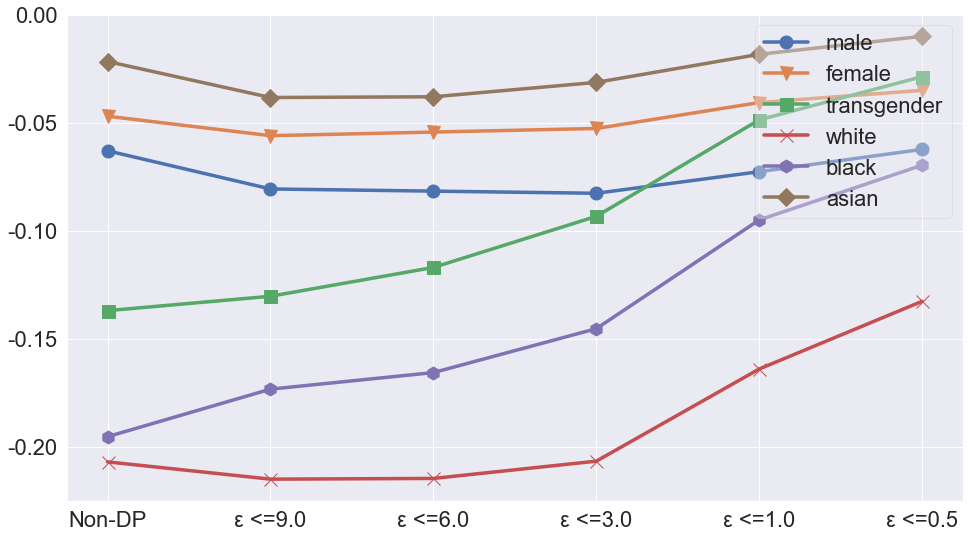

In [52]:
for metric in ['posAEG', 'negAEG']:
    print(metric)
    plot_bias_by_metric(metric, figure_name=f'{metric}.pdf')